In [1]:
import numpy as np
import numpy.random
import pandas as pd
from scipy.stats import halfnorm
from scipy.stats import truncexpon
from dowhy import gcm
import networkx as nx

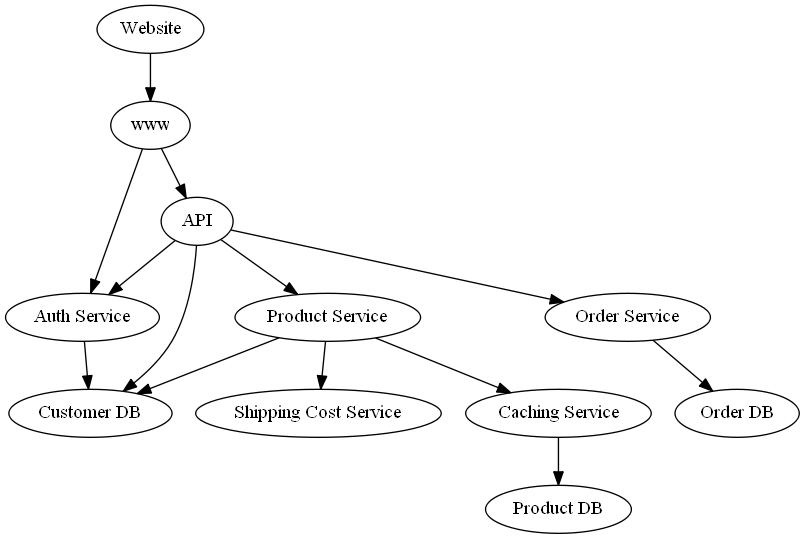

In [2]:
from IPython.display import Image
Image('microservice-architecture-dependencies.png', width=500) 

Estimating Shapley Values. Average change of Shapley values in run 7 (35 evaluated permutations): -15.840960861574304%: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


{'API': 0.0018052368915184962, 'Auth Service': 0.0010242945394873867, 'Caching Service': 1.8685093918691917, 'Customer DB': -0.00569716469799023, 'Order DB': -0.000266350255959288, 'Order Service': -0.0048789365772997605, 'Product DB': -0.005434608504218705, 'Product Service': 0.003679937979582082, 'Shipping Cost Service': 0.0022522002413884958, 'Website': -0.003969554302310931, 'www': -0.005814919714601479}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

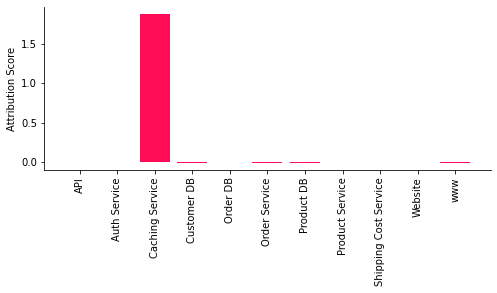

In [3]:
numpy.random.seed(5022)

def create_observed_latency_data(unobserved_intrinsic_latencies):
    observed_latencies = {}
    observed_latencies['Product DB'] = unobserved_intrinsic_latencies['Product DB']
    observed_latencies['Customer DB'] = unobserved_intrinsic_latencies['Customer DB']
    observed_latencies['Order DB'] = unobserved_intrinsic_latencies['Order DB']
    observed_latencies['Shipping Cost Service'] = unobserved_intrinsic_latencies['Shipping Cost Service']
    observed_latencies['Caching Service'] = np.random.choice([0, 1], size=(len(observed_latencies['Product DB']),),
                                                             p=[.5, .5]) * \
                                            observed_latencies['Product DB'] \
                                            + unobserved_intrinsic_latencies['Caching Service']
    observed_latencies['Product Service'] = np.maximum(np.maximum(observed_latencies['Shipping Cost Service'],
                                                                  observed_latencies['Caching Service']),
                                                       observed_latencies['Customer DB']) \
                                            + unobserved_intrinsic_latencies['Product Service']
    observed_latencies['Auth Service'] = observed_latencies['Customer DB'] \
                                         + unobserved_intrinsic_latencies['Auth Service']
    observed_latencies['Order Service'] = observed_latencies['Order DB'] \
                                          + unobserved_intrinsic_latencies['Order Service']
    observed_latencies['API'] = observed_latencies['Product Service'] \
                                + observed_latencies['Customer DB'] \
                                + observed_latencies['Auth Service'] \
                                + observed_latencies['Order Service'] \
                                + unobserved_intrinsic_latencies['API']
    observed_latencies['www'] = observed_latencies['API'] \
                                + observed_latencies['Auth Service'] \
                                + unobserved_intrinsic_latencies['www']
    observed_latencies['Website'] = observed_latencies['www'] \
                                    + unobserved_intrinsic_latencies['Website']

    return pd.DataFrame(observed_latencies)


def unobserved_intrinsic_latencies_normal(num_samples):
    return {
        'Website': truncexpon.rvs(size=num_samples, b=3, scale=0.2),
        'www': truncexpon.rvs(size=num_samples, b=2, scale=0.2),
        'API': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Auth Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Product Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Order Service': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Shipping Cost Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Caching Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.1),
        'Order DB': truncexpon.rvs(size=num_samples, b=5, scale=0.2),
        'Customer DB': truncexpon.rvs(size=num_samples, b=6, scale=0.2),
        'Product DB': truncexpon.rvs(size=num_samples, b=10, scale=0.2)
    }


def unobserved_intrinsic_latencies_anomalous(num_samples):
    return {
        'Website': truncexpon.rvs(size=num_samples, b=3, scale=0.2),
        'www': truncexpon.rvs(size=num_samples, b=2, scale=0.2),
        'API': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Auth Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Product Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Order Service': halfnorm.rvs(size=num_samples, loc=0.5, scale=0.2),
        'Shipping Cost Service': halfnorm.rvs(size=num_samples, loc=0.1, scale=0.2),
        'Caching Service': 2 + halfnorm.rvs(size=num_samples, loc=0.1, scale=0.1),
        'Order DB': truncexpon.rvs(size=num_samples, b=5, scale=0.2),
        'Customer DB': truncexpon.rvs(size=num_samples, b=6, scale=0.2),
        'Product DB': truncexpon.rvs(size=num_samples, b=10, scale=0.2)
    }


normal_data = create_observed_latency_data(unobserved_intrinsic_latencies_normal(10000))
outlier_data = create_observed_latency_data(unobserved_intrinsic_latencies_anomalous(1000))

causal_graph = nx.DiGraph([('www', 'Website'),
                           ('Auth Service', 'www'),
                           ('API', 'www'),
                           ('Customer DB', 'Auth Service'),
                           ('Customer DB', 'API'),
                           ('Product Service', 'API'),
                           ('Auth Service', 'API'),
                           ('Order Service', 'API'),
                           ('Shipping Cost Service', 'Product Service'),
                           ('Caching Service', 'Product Service'),
                           ('Product DB', 'Caching Service'),
                           ('Customer DB', 'Product Service'),
                           ('Order DB', 'Order Service')])

causal_model = gcm.StructuralCausalModel(causal_graph)

for node in causal_graph.nodes:
    if len(list(causal_graph.predecessors(node))) > 0:
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))

attribs = gcm.distribution_change(causal_model,
                                  normal_data.sample(frac=0.6),
                                  outlier_data.sample(frac=0.6),
                                  'Website',
                                  difference_estimation_func=lambda x, y: np.mean(y) - np.mean(x))

print(attribs)

def bar_plot(median_attribs, ylabel='Attribution Score', figsize=(8, 3), bwidth=0.8, xticks=None, xticks_rotation=90):
    fig, ax = plt.subplots(figsize=figsize)
    plt.bar(median_attribs.keys(), median_attribs.values(), ecolor='#1E88E5', color='#ff0d57', width=bwidth)
    plt.xticks(rotation=xticks_rotation)
    plt.ylabel(ylabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if xticks:
        plt.xticks(list(median_attribs.keys()), xticks)
    plt.show()

bar_plot(attribs)